<a href="https://colab.research.google.com/github/JF17-EngineerCivInd/JFP_challenge1-data-science-latam/blob/main/AluraStoreLatam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Alura Store LATAM ‚Äî Informe de An√°lisis** ##
**Objetivo:** Identificar la tienda menos eficiente para recomendar su venta.  
**Autor:** Jimmy Nicol√°s Flores Pinto  
**Fecha:** 18-08-2025

---


## **√çndice** ##
1. [Metodolog√≠a](#metodologia)
2. [Datos y preparaci√≥n](#datos)
3. [An√°lisis exploratorio](#eda)
   - 3.1. Facturaci√≥n por tienda
   - 3.2. Ventas por categor√≠a
   - 3.3. Calificaci√≥n promedio por tienda
   - 3.4. Productos m√°s y menos vendidos
   - 3.5. Costo de env√≠o promedio por tienda
4. [KPIs comparativos y recomendaci√≥n](#kpis)
5. [Conclusiones](#conclusiones)


## **1. Metodolog√≠a <a name="metodologia"></a>**
- Unificaci√≥n de las 4 tiendas en un √∫nico DataFrame (`df`) con etiqueta `Tienda`.
- Normalizaci√≥n de tipos (fechas, num√©ricos) y limpieza de nombres de columnas.
- M√©tricas por tienda: **Facturaci√≥n**, **Unidades vendidas**, **Calificaci√≥n promedio**, **Costo de env√≠o promedio**.
- Visualizaciones interactivas con **Plotly** y tablas de apoyo con **Pandas**.
- C√°lculo de un **score compuesto** (Min‚ÄìMax) con ponderaci√≥n:
  - Facturaci√≥n (40%), Calificaci√≥n (30%), Unidades (20%), Env√≠o (10%).


## **2. Datos y preparaci√≥n <a name="datos"></a>**
- Fuente: CSVs del repositorio del challenge (Trello/Alura).
- Estructura consolidada en `df` con columna `Tienda` (1 a 4).
- Moneda para *Precio* y *Costo de env√≠o*: **COP (Pesos Colombianos)**.


## **3. An√°lisis exploratorio <a name="eda"></a>**
A continuaci√≥n se presentan los an√°lisis solicitados.


### Importaci√≥n de datos



In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda1 = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda1.head()

Producto Categor√≠a del Producto    Precio  Costo de env√≠o  \
0  Asistente virtual           Electr√≥nicos  164300.0          6900.0   
1    Mesa de comedor                Muebles  192300.0          8400.0   
2      Juego de mesa               Juguetes  209600.0         15900.0   
3         Microondas      Electrodom√©sticos  757500.0         41000.0   
4   Silla de oficina                Muebles  335200.0         20200.0   

  Fecha de Compra         Vendedor Lugar de Compra  Calificaci√≥n  \
0      16/01/2021      Pedro Gomez          Bogot√°             4   
1      18/05/2022  Beatriz Morales        Medell√≠n             1   
2      15/03/2021   Juan Fernandez       Cartagena             1   
3      03/05/2022   Juan Fernandez            Cali             4   
4      07/11/2020    Maria Alfonso        Medell√≠n             5   

       M√©todo de pago  Cantidad de cuotas       lat       lon  
0  Tarjeta de cr√©dito                   8   4.60971 -74.08175  
1  Tarjeta de cr√©dito                   4   6.25184 -75.56359  
2  Tarjeta de cr√©dito                   1  10.39972 -75.51444  
3               Nequi                   1   3.43722 -76.52250  
4               Nequi                   1   6.25184 -75.56359

In [3]:
# === PASO 1: Preparaci√≥n (unir tiendas y tipificar datos) ===
import pandas as pd

# 1) Detecta c√≥mo se llaman tus dataframes
opciones = [
    ('tienda1','tienda2','tienda3','tienda4'),
    ('tienda_1','tienda_2','tienda_3','tienda_4'),
]
encontrado = False
for a,b,c,d in opciones:
    if all(n in globals() for n in (a,b,c,d)):
        tienda1, tienda2, tienda3, tienda4 = [globals()[n].copy() for n in (a,b,c,d)]
        encontrado = True
        break
if not encontrado:
    raise NameError("No encuentro los DataFrames de tiendas. Ejecuta antes la celda de importaci√≥n.")

# 2) Etiqueta cada tienda
for i, tdf in enumerate([tienda1, tienda2, tienda3, tienda4], start=1):
    tdf['Tienda'] = f'Tienda {i}'

# 3) Une todo
df = pd.concat([tienda1, tienda2, tienda3, tienda4], ignore_index=True)
df.columns = [c.strip() for c in df.columns]  # limpia espacios en nombres

# 4) Fecha de compra -> datetime (busca la columna por nombre aproximado)
fecha_col = next((c for c in df.columns if c.lower().startswith('fecha') and 'compra' in c.lower()), None)
if fecha_col:
    df[fecha_col] = pd.to_datetime(df[fecha_col], dayfirst=True, errors='coerce')

# 5) Convierte a num√©rico columnas clave si existen
candidatas_num = ['precio','costo de env√≠o','calificaci√≥n','cantidad de cuotas','emi','late']
for c in df.columns:
    if any(pal in c.lower() for pal in candidatas_num):
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 6) Vista r√°pida
print("Filas y columnas:", df.shape)
display(df.head())
display(df.dtypes)


Filas y columnas: (9435, 13)


Producto Categor√≠a del Producto    Precio  Costo de env√≠o  \
0  Asistente virtual           Electr√≥nicos  164300.0          6900.0   
1    Mesa de comedor                Muebles  192300.0          8400.0   
2      Juego de mesa               Juguetes  209600.0         15900.0   
3         Microondas      Electrodom√©sticos  757500.0         41000.0   
4   Silla de oficina                Muebles  335200.0         20200.0   

  Fecha de Compra         Vendedor Lugar de Compra  Calificaci√≥n  \
0      2021-01-16      Pedro Gomez          Bogot√°             4   
1      2022-05-18  Beatriz Morales        Medell√≠n             1   
2      2021-03-15   Juan Fernandez       Cartagena             1   
3      2022-05-03   Juan Fernandez            Cali             4   
4      2020-11-07    Maria Alfonso        Medell√≠n             5   

       M√©todo de pago  Cantidad de cuotas       lat       lon    Tienda  
0  Tarjeta de cr√©dito                   8   4.60971 -74.08175  Tienda 1  
1  Tarjeta de cr√©dito                   4   6.25184 -75.56359  Tienda 1  
2  Tarjeta de cr√©dito                   1  10.39972 -75.51444  Tienda 1  
3               Nequi                   1   3.43722 -76.52250  Tienda 1  
4               Nequi                   1   6.25184 -75.56359  Tienda 1

Producto                          object
Categor√≠a del Producto            object
Precio                           float64
Costo de env√≠o                   float64
Fecha de Compra           datetime64[ns]
Vendedor                          object
Lugar de Compra                   object
Calificaci√≥n                       int64
M√©todo de pago                    object
Cantidad de cuotas                 int64
lat                              float64
lon                              float64
Tienda                            object
dtype: object

## **Template Base** ##

In [4]:
# === TEMPLATE UTILIDADES + GR√ÅFICOS (Plotly) ===
# Deja este bloque en una sola celda al inicio del notebook.
import pandas as pd
import plotly.express as px

# ‚öôÔ∏è Par√°metros globales (puedes cambiarlos)
MONEDA = "COP (Pesos Colombianos)"  # etiqueta por defecto para montos
ANCHO, ALTO = 680, 420              # tama√±o por defecto de gr√°ficos
BWIDTH = 0.4                        # grosor por defecto de las barras

# -------------------- AGRUPAMIENTOS R√ÅPIDOS --------------------
def group_sum(df, by, value_col):
    """Suma value_col por claves 'by' (string o lista). √ötil para facturaci√≥n/costos."""
    g = df.groupby(by, dropna=False)[value_col].sum().reset_index()
    return g.sort_values(value_col, ascending=False)

def group_mean(df, by, value_col):
    """Promedio de value_col por claves 'by'. √ötil para calificaciones, tiempos, etc."""
    g = df.groupby(by, dropna=False)[value_col].mean().reset_index()
    return g.sort_values(value_col, ascending=False)

def group_count(df, by, count_col='Producto'):
    """Conteo por claves 'by'. √ötil para # de ventas, # de productos, etc."""
    g = df.groupby(by, dropna=False)[count_col].count().reset_index(name='Conteo')
    return g.sort_values('Conteo', ascending=False)

# -------------------- ESCALA Y FORMATOS (MONETARIO) --------------------
def _scale_and_formats(series, en_millones=True, etiqueta_moneda=MONEDA):
    """
    Escala serie (millones o valor completo) y devuelve:
    - serie escalada
    - etiqueta Y
    - formato de ticks
    - plantilla de hover
    """
    if en_millones:
        s = series / 1_000_000
        ylabel  = f"Millones de {etiqueta_moneda}"
        tickfmt = ',.2f'
        hover   = '<b>%{x}</b><br>Valor: %{y:,.2f} MM<extra></extra>'
    else:
        s = series
        ylabel  = etiqueta_moneda
        tickfmt = ',.0f'
        hover   = '<b>%{x}</b><br>Valor: %{y:,.0f}<extra></extra>'
    return s, ylabel, tickfmt, hover

# -------------------- GR√ÅFICOS: BARRAS (SIMPLE) --------------------
def plot_bar(df_plot, x, y, titulo, ylabel=None, color=None,
             en_millones=False, ancho=ANCHO, alto=ALTO, barwidth=BWIDTH, centrar_titulo=True):
    """
    Barra simple (una m√©trica por categor√≠a).
    - en_millones=True solo si 'y' es monetario (facturaci√≥n, costo, etc.)
    - color: columna para colorear (ej: 'Tienda') o None
    """
    data_y = df_plot[y]
    if ylabel is None and en_millones:  # monetario ‚Üí formateo especial
        data_y, ylabel, tickfmt, hover = _scale_and_formats(data_y, True)
        df_plot = df_plot.copy(); df_plot[y] = data_y
    elif ylabel is None:
        ylabel, tickfmt = y, ',.0f'
        hover = '<b>%{x}</b><br>Valor: %{y:,.0f}<extra></extra>'

    fig = px.bar(df_plot, x=x, y=y, color=color, title=titulo, labels={x:'', y: ylabel})
    fig.update_traces(hovertemplate=hover, width=barwidth)
    fig.update_layout(
        width=ancho, height=alto,
        yaxis=dict(tickformat=tickfmt, showline=True, linewidth=1),
        xaxis=dict(showline=True, linewidth=1),
        margin=dict(l=40, r=20, t=50, b=40),
        title={'x':0.5} if centrar_titulo else None
    )
    fig.show()

# -------------------- GR√ÅFICOS: BARRAS (AGRUPADAS / APILADAS) --------------------
def plot_bar_multi(df_plot, x, y, color, titulo, modo='group',
                   ylabel=None, en_millones=False, ancho=ANCHO, alto=ALTO, barwidth=BWIDTH):
    """
    Barras con varias series (por ejemplo, categor√≠as por tienda).
    - modo='group' (agrupadas) o 'stack' (apiladas)
    - en_millones=True solo si 'y' es monetario
    """
    data_y = df_plot[y]
    if ylabel is None and en_millones:
        data_y, ylabel, tickfmt, hover = _scale_and_formats(data_y, True)
        df_plot = df_plot.copy(); df_plot[y] = data_y
    elif ylabel is None:
        ylabel, tickfmt = y, ',.0f'
        hover = '<b>%{x}</b><br>%{fullData.name}: %{y:,.0f}<extra></extra>'

    fig = px.bar(df_plot, x=x, y=y, color=color, title=titulo, labels={x:'', y: ylabel})
    fig.update_traces(hovertemplate=hover, width=barwidth)
    fig.update_layout(
        width=ancho, height=alto, barmode=('stack' if modo=='stack' else 'group'),
        yaxis=dict(tickformat=tickfmt, showline=True, linewidth=1),
        xaxis=dict(showline=True, linewidth=1),
        margin=dict(l=40, r=20, t=50, b=40),
        title={'x':0.5}
    )
    fig.show()

# -------------------- GR√ÅFICO: ROSCA / PIE --------------------
def plot_pie(df_plot, names, values, titulo):
    """Proporciones (ej: participaci√≥n por categor√≠a)."""
    fig = px.pie(df_plot, names=names, values=values, title=titulo, hole=0.3)
    fig.update_traces(textinfo='percent+label',
                      hovertemplate='<b>%{label}</b><br>Valor: %{value}<extra></extra>')
    fig.update_layout(title={'x':0.5}, width=ANCHO, height=ALTO)
    fig.show()

# -------------------- GR√ÅFICO: BOXPLOT --------------------
def plot_box(df, x, y, titulo, color=None):
    """Distribuci√≥n y dispersi√≥n (ej: calificaci√≥n por tienda)."""
    fig = px.box(df, x=x, y=y, color=color, title=titulo, points="all")
    fig.update_layout(width=ANCHO, height=ALTO, title={'x':0.5})
    fig.show()

# -------------------- GR√ÅFICO: L√çNEA --------------------
def plot_line(df_plot, x, y, titulo, color=None, ylabel=None):
    """Tendencia en el tiempo (ej: ventas por fecha)."""
    fig = px.line(df_plot, x=x, y=y, color=color, title=titulo, labels={x:'', y: (ylabel or y)})
    fig.update_layout(width=ANCHO, height=ALTO, title={'x':0.5})
    fig.show()


# -------------------- Suite para grafico 3.2 --------------------
def plot_cat_lines(g_cat, cat_col, top_n=None, width=820, height=480):
    """
    L√≠nea √∫nica con 4 tiendas (una l√≠nea por tienda) vs categor√≠as en el eje X.
    - g_cat: DataFrame con columnas ['Tienda', cat_col, 'Conteo'] (sale de group_count).
    - top_n: si pones un n√∫mero, limita a las categor√≠as m√°s vendidas (evita amontonamiento).
    """
    # Orden global de categor√≠as por volumen total
    order = (g_cat.groupby(cat_col)['Conteo'].sum()
             .sort_values(ascending=False).index.tolist())
    if top_n:
        order = order[:top_n]

    gc = g_cat[g_cat[cat_col].isin(order)].copy()
    gc[cat_col] = pd.Categorical(gc[cat_col], categories=order, ordered=True)

    fig = px.line(
        gc.sort_values(cat_col),
        x=cat_col, y='Conteo', color='Tienda', markers=True,
        title='Ventas por categor√≠a ‚Äî perfil por tienda',
        labels={cat_col:'Categor√≠a', 'Conteo':'Unidades', 'Tienda':''}
    )
    fig.update_traces(line=dict(width=2))
    fig.update_layout(
        width=width, height=height,
        xaxis=dict(showline=True, linewidth=1, tickangle=-20,
                   categoryorder='array', categoryarray=order),
        yaxis=dict(showline=True, linewidth=1),
        legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5,
                    itemclick='toggle', itemdoubleclick='toggleothers'),
        margin=dict(l=40, r=20, t=60, b=70),
        title={'x':0.5}
    )
    fig.show()


# -------------------- Suite para grafico 3.3 --------------------
# L√≠nea simple. Usa PALETTE_TIENDAS si x == 'Tienda'
def plot_line_simple(df_, x, y, title, y_range=None, width=820, height=480):
    import pandas as pd, plotly.express as px
    d = df_.copy()
    if x == 'Tienda':  # orden Tienda 1..4
        orden = sorted(d[x].unique(), key=lambda t: int(str(t).split()[-1]))
        d[x] = pd.Categorical(d[x], categories=orden, ordered=True)
    fig = px.line(
        d.sort_values(x), x=x, y=y,
        color=(x if x=='Tienda' else None), markers=True,
        color_discrete_map=(PALETTE_TIENDAS if x=='Tienda' else None),
        title=title, labels={x:'', y:y}
    )
    fig.update_traces(line=dict(width=3), hovertemplate='%{x}<br>%{y:.2f}<extra></extra>')
    fig.update_layout(
        width=width, height=height,
        yaxis=dict(range=y_range, dtick=(1 if y_range==[0,5] else None), showline=True, linewidth=1),
        xaxis=dict(showline=True, linewidth=1),
        legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5,
                    itemclick='toggle', itemdoubleclick='toggleothers'),
        margin=dict(l=40, r=20, t=60, b=70), title={'x':0.5}
    )
    fig.show()


#3.1. An√°lisis de facturaci√≥n



In [5]:
# FACTURACI√ìN POR TIENDA (tabla)
precio_col = next(c for c in df.columns if 'precio' in c.lower())
g_fact = group_sum(df, by='Tienda', value_col=precio_col)
display(g_fact.round(0))


Tienda        Precio
0  Tienda 1  1.150880e+09
1  Tienda 2  1.116344e+09
2  Tienda 3  1.098020e+09
3  Tienda 4  1.038376e+09

In [6]:
# FACTURACI√ìN POR TIENDA (gr√°fico interactivo)
plot_bar(g_fact, x='Tienda', y=precio_col,
         titulo='Facturaci√≥n por tienda',
         color='Tienda', en_millones=True)


# 3.2. Ventas por categor√≠a

In [7]:
# VENTAS POR CATEGOR√çA (tabla)
cat_col = next(c for c in df.columns if 'categor' in c.lower())
prod_col = next(c for c in df.columns if 'producto' in c.lower())

g_cat = group_count(df, by=['Tienda', cat_col], count_col=prod_col)
display(g_cat.head(10))

pivot_cat = g_cat.pivot(index=cat_col, columns='Tienda', values='Conteo').fillna(0).astype(int)
display(pivot_cat)


Tienda Categor√≠a del Producto  Conteo
23  Tienda 3                Muebles     499
31  Tienda 4                Muebles     480
7   Tienda 1                Muebles     465
27  Tienda 4           Electr√≥nicos     451
19  Tienda 3           Electr√≥nicos     451
3   Tienda 1           Electr√≥nicos     448
15  Tienda 2                Muebles     442
11  Tienda 2           Electr√≥nicos     422
29  Tienda 4               Juguetes     338
5   Tienda 1               Juguetes     324

Tienda                   Tienda 1  Tienda 2  Tienda 3  Tienda 4
Categor√≠a del Producto                                         
Art√≠culos para el hogar       171       181       177       201
Deportes y diversi√≥n          284       275       277       277
Electrodom√©sticos             312       305       278       254
Electr√≥nicos                  448       422       451       451
Instrumentos musicales        182       224       177       170
Juguetes                      324       313       315       338
Libros                        173       197       185       187
Muebles                       465       442       499       480

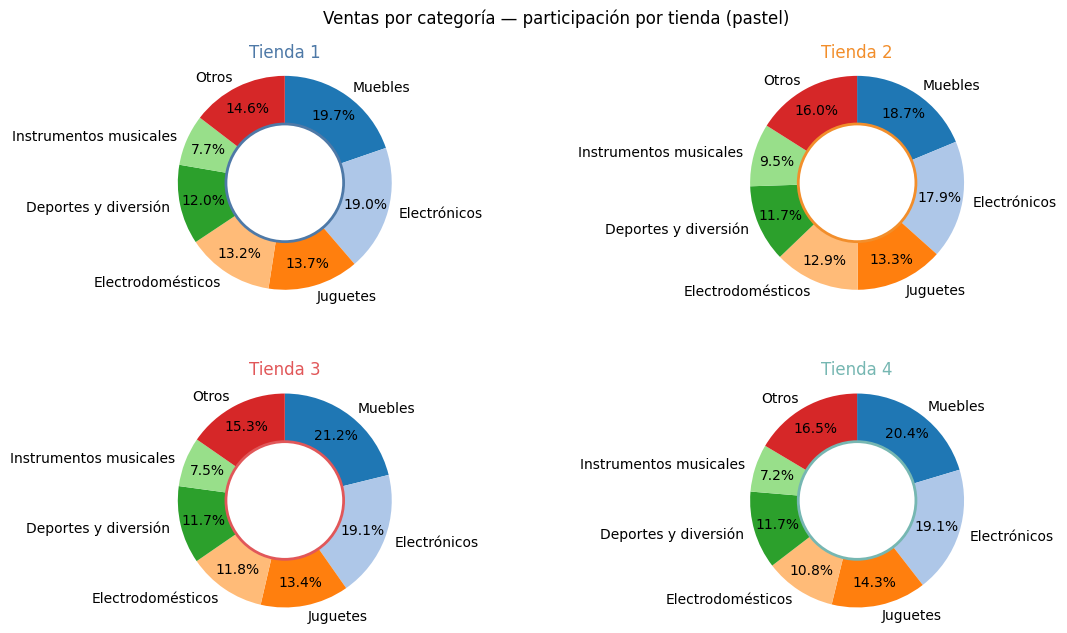

In [8]:
# 3.2 ‚Äî Ventas por categor√≠a
import matplotlib.pyplot as plt

# --- columnas ---
cat_col  = next(c for c in df.columns if 'categor' in c.lower())
prod_col = next(c for c in df.columns if 'producto' in c.lower())

# --- conteos Tienda x Categor√≠a ---
pivot = df.groupby(['Tienda', cat_col])[prod_col].count().unstack(fill_value=0)

# orden global y TOP_N
orden_global = pivot.sum(axis=0).sort_values(ascending=False)
TOP_N = 6
cats_top = list(orden_global.index[:TOP_N])
otros = pivot.drop(columns=cats_top).sum(axis=1)

pivot_top = pivot[cats_top].copy()
if (pivot.shape[1] - TOP_N) > 0:
    pivot_top['Otros'] = otros

# colores de tienda (como 3.1)
PALETTE_TIENDAS = {
    'Tienda 1': '#4E79A7',
    'Tienda 2': '#F28E2B',
    'Tienda 3': '#E15759',
    'Tienda 4': '#76B7B2',
}
# colores por categor√≠a (consistentes en los 4 pies)
cmap = plt.get_cmap('tab20')
cats = pivot_top.columns.tolist()
COL_CAT = {c: cmap(i % 20) for i, c in enumerate(cats)}

# --- m√°s espacio horizontal entre subplots ---
fig, axes = plt.subplots(
    2, 2, figsize=(12, 7),                # un poco m√°s ancho
    gridspec_kw={'wspace': 0.60, 'hspace': 0.35}   # <-- separaciones
)
axes = axes.ravel()

for ax, tienda in zip(axes, sorted(pivot_top.index)):
    vals = pivot_top.loc[tienda].values
    labels = pivot_top.columns.tolist()
    colors = [COL_CAT[c] for c in labels]

    wedges, texts, autotexts = ax.pie(
        vals, labels=labels, colors=colors,
        autopct=lambda p: f'{p:.1f}%' if p >= 3 else '',
        startangle=90, counterclock=False, pctdistance=0.78
    )
    aro = plt.Circle((0, 0), 0.55, fc='white',
                     edgecolor=PALETTE_TIENDAS.get(tienda, 'gray'), lw=2)
    ax.add_artist(aro)
    ax.set_title(tienda, color=PALETTE_TIENDAS.get(tienda, 'black'))
    ax.axis('equal')

fig.suptitle('Ventas por categor√≠a ‚Äî participaci√≥n por tienda (pastel)', y=0.98)
# aseguramos que la separaci√≥n se mantenga
fig.subplots_adjust(wspace=0.60, hspace=0.35, top=0.90)
plt.show()


# 3.3. Calificaci√≥n promedio de la tienda


In [9]:
# CALIFICACI√ìN PROMEDIO POR TIENDA (tabla)
calif_col = next(c for c in df.columns if 'calificaci√≥n' in c.lower())
g_calif = group_mean(df, by='Tienda', value_col=calif_col)
display(g_calif.round(2))


Tienda  Calificaci√≥n
2  Tienda 3          4.05
1  Tienda 2          4.04
3  Tienda 4          4.00
0  Tienda 1          3.98

In [10]:
# CALIFICACI√ìN PROMEDIO POR TIENDA (gr√°fico con rango fijo)
import plotly.express as px

fig = px.bar(g_calif,
             x='Tienda', y=calif_col, color='Tienda',
             title='Calificaci√≥n promedio por tienda',
             labels={'Tienda':'', calif_col:'Calificaci√≥n promedio'})
fig.update_traces(width=0.4)
fig.update_layout(
    width=680, height=420,
    yaxis=dict(range=[0,5], dtick=1, showline=True, linewidth=1),
    xaxis=dict(showline=True, linewidth=1),
    margin=dict(l=40, r=20, t=50, b=40),
    title={'x':0.5}
)
fig.show()



# 3.4. Productos m√°s y menos vendidos

In [11]:
# PRODUCTOS M√ÅS Y MENOS VENDIDOS ‚Äî Tablas por tienda
prod_col = next(c for c in df.columns if 'producto' in c.lower())
g_prod = group_count(df, by=['Tienda', prod_col], count_col=prod_col)

top5 = (g_prod.sort_values(['Tienda','Conteo'], ascending=[True, False])
              .groupby('Tienda', group_keys=False).head(5))

bottom5 = (g_prod.sort_values(['Tienda','Conteo'], ascending=[True, True])
                 .groupby('Tienda', group_keys=False).head(5))

print("üîù TOP 5 productos por tienda")
display(top5)

print("\nüîª BOTTOM 5 productos por tienda")
display(bottom5)


üîù TOP 5 productos por tienda


Tienda                   Producto  Conteo
48   Tienda 1              TV LED UHD 4K      60
33   Tienda 1                 Microondas      60
1    Tienda 1                    Armario      60
40   Tienda 1           Secadora de ropa      58
32   Tienda 1              Mesa de noche      56
75   Tienda 2  Iniciando en programaci√≥n      65
84   Tienda 2                 Microondas      62
58   Tienda 2                    Bater√≠a      61
89   Tienda 2                  Pandereta      58
72   Tienda 2          Guitarra ac√∫stica      58
129  Tienda 3              Kit de bancas      57
113  Tienda 3                  Cama king      56
133  Tienda 3            Mesa de comedor      56
134  Tienda 3              Mesa de noche      55
143  Tienda 3               Set de ollas      55
163  Tienda 4                   Cama box      62
168  Tienda 4                 Cuberter√≠a      59
164  Tienda 4                  Cama king      56
171  Tienda 4    Dashboards con Power BI      56
165  Tienda 4  Carrito de control remoto      55


üîª BOTTOM 5 productos por tienda


Tienda                     Producto  Conteo
13   Tienda 1                 Celular ABXY      33
4    Tienda 1    Auriculares con micr√≥fono      33
37   Tienda 1              Olla de presi√≥n      35
38   Tienda 1                    Pandereta      36
34   Tienda 1                      Mochila      39
77   Tienda 2                Juego de mesa      32
74   Tienda 2                    Impresora      34
82   Tienda 2              Mesa de comedor      34
95   Tienda 2                       Sill√≥n      35
54   Tienda 2                  Auriculares      37
111  Tienda 3      Bloques de construcci√≥n      35
135  Tienda 3                   Microondas      36
136  Tienda 3                      Mochila      36
144  Tienda 3                 Set de vasos      36
124  Tienda 3           Guitarra el√©ctrica      38
175  Tienda 4           Guitarra el√©ctrica      33
154  Tienda 4                      Armario      34
174  Tienda 4            Guitarra ac√∫stica      37
167  Tienda 4  Ciencia de datos con Python      38
181  Tienda 4             Lavadora de ropa      38

In [17]:
# 3.4 ‚Äî Top 5 productos m√°s vendidos por tienda (orden ‚Üì, m√°s espacio)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

prod_col = next(c for c in df.columns if 'producto' in c.lower())

# Conteo y top-5 por tienda
g_prod = group_count(df, by=['Tienda', prod_col], count_col=prod_col)
top5   = (g_prod.sort_values(['Tienda','Conteo'], ascending=[True, False])
                .groupby('Tienda', group_keys=False).head(5))

orden_t = sorted(top5['Tienda'].unique(), key=lambda t: int(str(t).split()[-1]))

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=orden_t,
    horizontal_spacing=0.20,    # ‚Üê m√°s espacio entre columnas
    vertical_spacing=0.16
)

for i, t in enumerate(orden_t):
    r, c = i//2 + 1, i%2 + 1
    dfi = top5[top5['Tienda']==t].sort_values('Conteo', ascending=False)  # mayor‚Üímenor

    fig.add_bar(
        x=dfi['Conteo'], y=dfi[prod_col], orientation='h',
        marker_color=PALETTE_TIENDAS.get(t, '#6e6e6e'),
        text=dfi['Conteo'], textposition='outside', cliponaxis=False,
        width=0.85,  # barras un poquito m√°s gruesas
        row=r, col=c
    )

    # Orden de categor√≠as y que el primero aparezca ARRIBA
    fig.update_yaxes(
        categoryorder='array',
        categoryarray=dfi[prod_col].tolist(),
        autorange='reversed',
        showline=True, linewidth=1,
        row=r, col=c
    )
    fig.update_xaxes(showline=True, linewidth=1, row=r, col=c)

fig.update_layout(
    title={'text':'Top 5 productos m√°s vendidos por tienda', 'x':0.5, 'y':0.98},
    width=1100, height=720, bargap=0.15,
    margin=dict(l=100, r=20, t=100, b=50),   # ‚Üê mayor separaci√≥n del t√≠tulo
    showlegend=False
)

fig.show()


# 3.5. Env√≠o promedio por tienda

In [13]:
# COSTO DE ENV√çO PROMEDIO POR TIENDA ‚Äî tabla
envio_col = next(c for c in df.columns if ('costo' in c.lower()) and ('env' in c.lower()))
g_envio = group_mean(df, by='Tienda', value_col=envio_col)
display(g_envio.round(0))


Tienda  Costo de env√≠o
0  Tienda 1         26019.0
1  Tienda 2         25216.0
2  Tienda 3         24806.0
3  Tienda 4         23459.0

In [14]:
# COSTO DE ENV√çO PROMEDIO POR TIENDA ‚Äî gr√°fico
plot_bar(g_envio, x='Tienda', y=envio_col,
         titulo='Costo de env√≠o promedio por tienda',
         color='Tienda', en_millones=True)


## **4. KPIs comparativos y recomendaci√≥n <a name="kpis"></a>**
Resumen de desempe√±o por tienda y **score** compuesto para priorizar la decisi√≥n de venta.


In [15]:
# === RESUMEN DE KPIs + RECOMENDACI√ìN FINAL ===
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

precio_col = next(c for c in df.columns if 'precio' in c.lower())
calif_col  = next(c for c in df.columns if 'calif'  in c.lower())
envio_col  = next(c for c in df.columns if ('costo' in c.lower() and 'env' in c.lower()))
prod_col   = next(c for c in df.columns if 'producto' in c.lower())

kpis = pd.DataFrame({
    'Facturaci√≥n': df.groupby('Tienda')[precio_col].sum(),
    'Calificaci√≥n_prom': df.groupby('Tienda')[calif_col].mean(),
    'Env√≠o_prom': df.groupby('Tienda')[envio_col].mean(),
    'Unidades': df.groupby('Tienda')[prod_col].count()
})

def minmax(s):
    mn, mx = s.min(), s.max()
    return (s - mn) / (mx - mn) if mx > mn else pd.Series(0.5, index=s.index)

w_fact, w_calif, w_unid, w_env = 0.40, 0.30, 0.20, 0.10

kpis['fact_norm']  = minmax(kpis['Facturaci√≥n'])
kpis['calif_norm'] = minmax(kpis['Calificaci√≥n_prom'])
kpis['unid_norm']  = minmax(kpis['Unidades'])
kpis['env_norm']   = 1 - minmax(kpis['Env√≠o_prom'])  # menor costo = mejor

kpis['Score'] = (w_fact*kpis['fact_norm'] +
                 w_calif*kpis['calif_norm'] +
                 w_unid*kpis['unid_norm'] +
                 w_env*kpis['env_norm'])

kpis_orden = kpis.sort_values('Score', ascending=False).round(3)
tienda_menos_ef = kpis_orden.index[-1]
tienda_mejor    = kpis_orden.index[0]

display(kpis_orden[['Facturaci√≥n','Calificaci√≥n_prom','Env√≠o_prom','Unidades','Score']])

row = kpis.loc[tienda_menos_ef]
def qual(val, serie, alto_mejor=True):
    mn, mx = serie.min(), serie.max()
    if mx == mn: return "similar al resto"
    terc1, terc2 = mn + (mx-mn)/3, mn + 2*(mx-mn)/3
    if alto_mejor:
        return "alto" if val >= terc2 else ("bajo" if val <= terc1 else "medio")
    else:
        return "bajo (mejor)" if val <= terc1 else ("alto (peor)" if val >= terc2 else "medio")

md = f"""
**Recomendaci√≥n:** Vender **{tienda_menos_ef}**.

**Resumen de {tienda_menos_ef}:**
- Facturaci√≥n: {qual(row['Facturaci√≥n'], kpis['Facturaci√≥n'], True)}
- Unidades vendidas: {qual(row['Unidades'], kpis['Unidades'], True)}
- Calificaci√≥n promedio: {qual(row['Calificaci√≥n_prom'], kpis['Calificaci√≥n_prom'], True)}
- Costo de env√≠o promedio: {qual(row['Env√≠o_prom'], kpis['Env√≠o_prom'], False)}

**Mejor desempe√±o general:** {tienda_mejor} (score m√°s alto).
"""
display(Markdown(md))


Facturaci√≥n  Calificaci√≥n_prom  Env√≠o_prom  Unidades  Score
Tienda                                                                
Tienda 2  1.116344e+09              4.037   25216.236      2359  0.762
Tienda 3  1.098020e+09              4.048   24805.680      2359  0.759
Tienda 1  1.150880e+09              3.977   26018.610      2359  0.600
Tienda 4  1.038376e+09              3.996   23459.457      2358  0.180


**Recomendaci√≥n:** Vender **Tienda 4**.

**Resumen de Tienda 4:**
- Facturaci√≥n: bajo
- Unidades vendidas: bajo
- Calificaci√≥n promedio: bajo
- Costo de env√≠o promedio: bajo (mejor)

**Mejor desempe√±o general:** Tienda 2 (score m√°s alto).


## 5. Conclusiones

- **Tienda recomendada para vender:** **Tienda 4**.
- **Fundamentos (posici√≥n dentro de 4 tiendas, 1=mejor):**
  - **Facturaci√≥n:** 1.038.38 MM COP (**4/4**).
  - **Unidades vendidas:** 2.358 (**4/4**).
  - **Calificaci√≥n promedio:** 4.00 (**3/4**).
  - **Costo de env√≠o promedio:** 0.02 MM COP (**1/4**, *menor es mejor*).
- **Mejor desempe√±o general:** **Tienda 2** (score m√°s alto).

> **Nota:**

  El *score* compuesto pondera
  - Facturaci√≥n (40%)
  - Calificaci√≥n (30%)
  - Unidades (20%)
  - Env√≠o (10%).
